# Exploring Mckinsey (EDA-Baseline)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import lightgbm as lgb
from collections import Counter
from scipy import stats
from sklearn.metrics import roc_curve,auc
from sklearn import preprocessing, model_selection, metrics
from sklearn import ensemble
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_predict

color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 60

In [2]:
def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

# apply the Box-Cox transformations on the continuous data
def preproc_quantitatives(X):
    Y = X.copy()

    # apply Box-Cox transformations on non-missing values
    not_missing = Y[~Y.isnull()].copy()
    not_missing = not_missing - np.min(not_missing) + 1e-10  # to avoid errors with non-positive values
    res = stats.boxcox(not_missing)
    Y[~Y.isnull()] = res[0]

    # normalize non-missing values
    mu = np.mean(Y[~Y.isnull()])
    sigma = Y[~Y.isnull()].std()
    Y = (Y - mu) / sigma

    # fill missing values with means
    Y[Y.isnull()] = 0.0

    return Y


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Import Data

In [3]:
NUMSAMPLE = 5000
train_df = pd.read_csv("./data/train_ZoGVYWq.csv",nrows=None)
test_df = pd.read_csv("./data/test_66516Ee.csv",nrows=None)
sample_df = pd.read_csv("./data/sample_submission_sLex1ul.csv")
print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)
print("Sample rows and columns : ", sample_df.shape)

Train rows and columns :  (79853, 13)
Test rows and columns :  (34224, 12)
Sample rows and columns :  (34224, 3)


In [4]:
train_df.dtypes

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
renewal                               int64
dtype: object

# Distribution of target value
The distribution is skewed!

In [5]:
train_df['renewal'].describe()

count    79853.000000
mean         0.937410
std          0.242226
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: renewal, dtype: float64

In [6]:
# train_df.head()

In [7]:
# test_df.head()

In [8]:
# sample_df.head()

**note**: You have information about past transactions from the policy holders along with their demographics. The client has provided aggregated historical transactional data like number of premiums delayed by 3/ 6/ 12 months across all the products, number of premiums paid, customer sourcing channel and customer demographics like age, monthly income and area type.


perc_premium_paid_by_cash_credit : Percentage of premium amount paid by cash or credit card

# Effort and Incentive

#### Relationship b/w Extra efforts in hours invested by an agent and Incentive to agent. 
After a point more incentives does not convert to extra efforts.

$$Effort\: by\: incentive\: curve = 10*(1- e^{(-incentive/400)})$$


In [9]:
# Equation for the effort-incentives curve: 
def effort_incentive_curve(incentive):
    effort = 10*(1-np.exp(-incentive/400))
    return effort

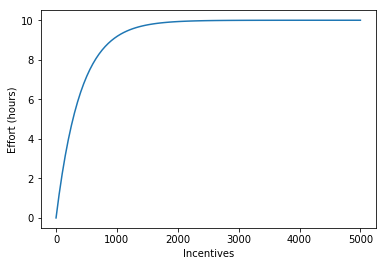

In [10]:
incentive = np.linspace(0,5000,100)

effort_in_hours = effort_incentive_curve(incentive)

# effort_in_hours

plt.plot(incentive,effort_in_hours)
plt.xlabel('Incentives')
plt.ylabel('Effort (hours)')
plt.show()

#### Relationship between % improvement in renewal probability vs Agent effort in hours. 
The renewal probability cannot be improved beyond a certain level even with more efforts.

$$Probability\: incerease\: in\: renewal\: by\: effort\: curve = 20*(1- e^{(-effort/5)})$$

In [11]:
# Equation for the % improvement in renewal prob vs effort curve: 
def renewal_effort_curve(effort):
    renewal = 20*(1-np.exp(-effort/5))
    return renewal

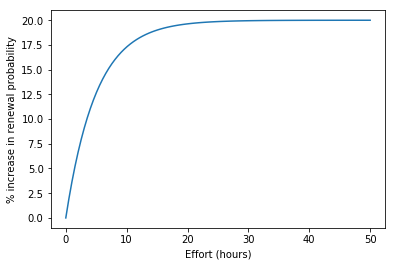

In [12]:
effort_hour = np.linspace(0,50,100)

renewal_prob_increase = renewal_effort_curve(effort_hour)

# renewal_prob_increase

plt.plot(effort_hour,renewal_prob_increase)
plt.xlabel('Effort (hours)')
plt.ylabel('% increase in renewal probability')
plt.show()

#### Relationship % improvement in renewal probability and Incentive to agent. 


In [13]:
renewal_prob_increase_by_incentive = renewal_effort_curve(effort_incentive_curve(incentive))

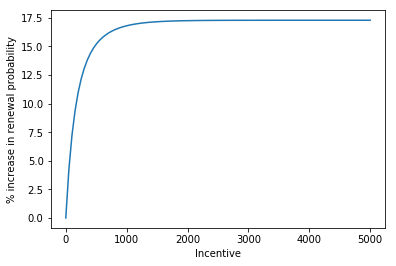

In [14]:
plt.plot(incentive,renewal_prob_increase_by_incentive)
plt.xlabel('Incentive')
plt.ylabel('% increase in renewal probability')
plt.show()

# Some Graphs

In [15]:
CATEGORICAL_COLUMNS = ["sourcing_channel",
                      'residence_area_type']

CONTINUOUS_COLUMNS = ['perc_premium_paid_by_cash_credit',
                      'age_in_days',
                      'Income',
                     'application_underwriting_score',
                     'premium']

DISCRETE_COLUMNS = ['Count_3-6_months_late',
                    'Count_6-12_months_late',
                   'Count_more_than_12_months_late',
                   'no_of_premiums_paid']

# DUMMY_COLUMNS = ["Medical_Keyword_{}".format(i) for i in range(1, 48)]

In [16]:
categorical_data = pd.concat([train_df[CATEGORICAL_COLUMNS], test_df[CATEGORICAL_COLUMNS]])
continuous_data = pd.concat([train_df[CONTINUOUS_COLUMNS], test_df[CONTINUOUS_COLUMNS]])
discrete_data = pd.concat([train_df[DISCRETE_COLUMNS], test_df[DISCRETE_COLUMNS]])

# Categorical Data

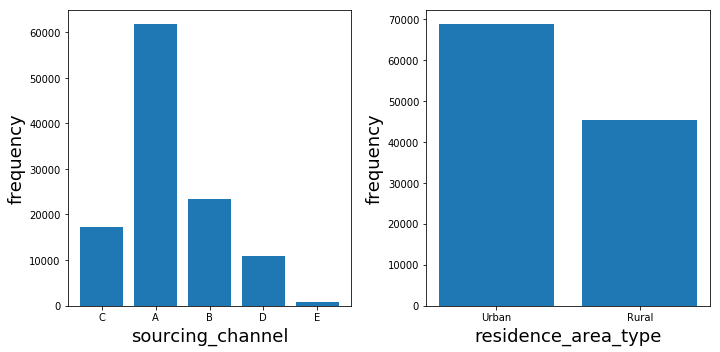

In [17]:
plot_categoricals(categorical_data)

In [18]:
categorical_data_bin = categorical_data.applymap(str)  # need to convert into strings to appyly get_dummies
categorical_data_bin = pd.get_dummies(categorical_data_bin, drop_first=True)

#### sourcing_channel : Sourcing channel for application

In [19]:
renewal_by_sourcing_channel = train_df.groupby(['sourcing_channel','renewal']).renewal.count().reset_index(level=0).reset_index(drop=True)

total_renewal_by_sourcing_channel = train_df.groupby(['sourcing_channel'])['renewal'].count().reset_index().rename(index=str, columns={"renewal": "total_renewal"})

merged_renewal_by_sourcing_channel = pd.merge(total_renewal_by_sourcing_channel,renewal_by_sourcing_channel)

merged_renewal_by_sourcing_channel

merged_renewal_by_sourcing_channel['percentages']=merged_renewal_by_sourcing_channel['renewal']/merged_renewal_by_sourcing_channel['total_renewal']

merged_renewal_by_sourcing_channel

,sourcing_channel,total_renewal,renewal,percentages
0,A,43134,2349,0.054458
1,A,43134,40785,0.945542
2,B,16512,1066,0.064559
3,B,16512,15446,0.935441
4,C,12039,903,0.075006
5,C,12039,11136,0.924994
6,D,7559,634,0.083874
7,D,7559,6925,0.916126
8,E,609,46,0.075534
9,E,609,563,0.924466


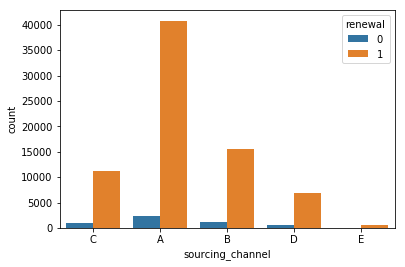

In [20]:
sns.countplot('sourcing_channel',hue='renewal',data=train_df);

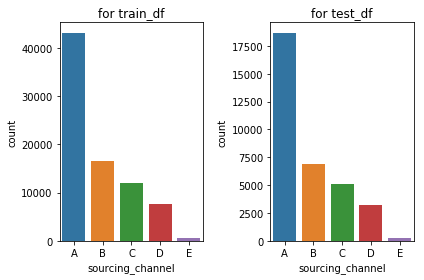

In [21]:
plt.subplot(1, 2, 1)
sns.countplot('sourcing_channel',order=['A','B',"C","D","E"],data=train_df);
plt.title('for train_df')
plt.subplot(1, 2, 2)
sns.countplot('sourcing_channel',order=['A','B',"C","D","E"],data=test_df);
plt.title('for test_df')
plt.tight_layout()

#### residence_area_type : Area type of Residence (Urban/Rural)

In [22]:
renewal_by_residence = train_df.groupby(['residence_area_type','renewal']).renewal.count().reset_index(level=0).reset_index(drop=True)

total_renewal_by_residence = train_df.groupby(['residence_area_type'])['renewal'].count().reset_index().rename(index=str, columns={"renewal": "total_renewal"})

merged_renewal_by_residence = pd.merge(total_renewal_by_residence,renewal_by_residence)

merged_renewal_by_residence['percentages']=merged_renewal_by_residence['renewal']/merged_renewal_by_residence['total_renewal']

merged_renewal_by_residence

,residence_area_type,total_renewal,renewal,percentages
0,Rural,31670,1998,0.063088
1,Rural,31670,29672,0.936912
2,Urban,48183,3000,0.062263
3,Urban,48183,45183,0.937737


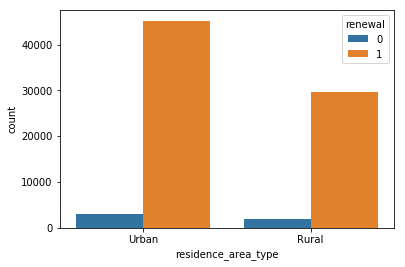

In [23]:
sns.countplot('residence_area_type',hue='renewal',data=train_df);

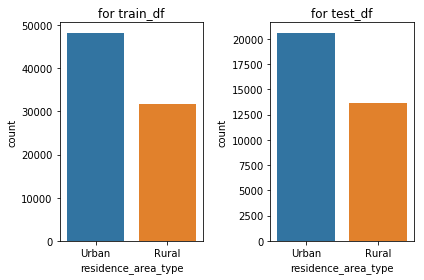

In [24]:
plt.subplot(1, 2, 1)
sns.countplot('residence_area_type',order=train_df['residence_area_type'].unique().tolist(),data=train_df);
plt.title('for train_df')
plt.subplot(1, 2, 2)
sns.countplot('residence_area_type',order=train_df['residence_area_type'].unique().tolist(),data=test_df);
plt.title('for test_df')
plt.tight_layout()

# Discrete Data

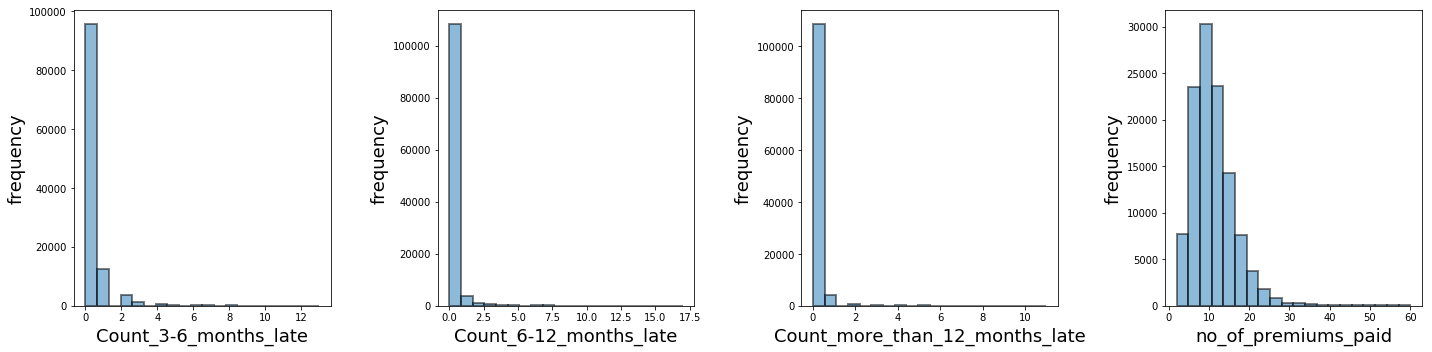

In [25]:
plot_histgrams(discrete_data)

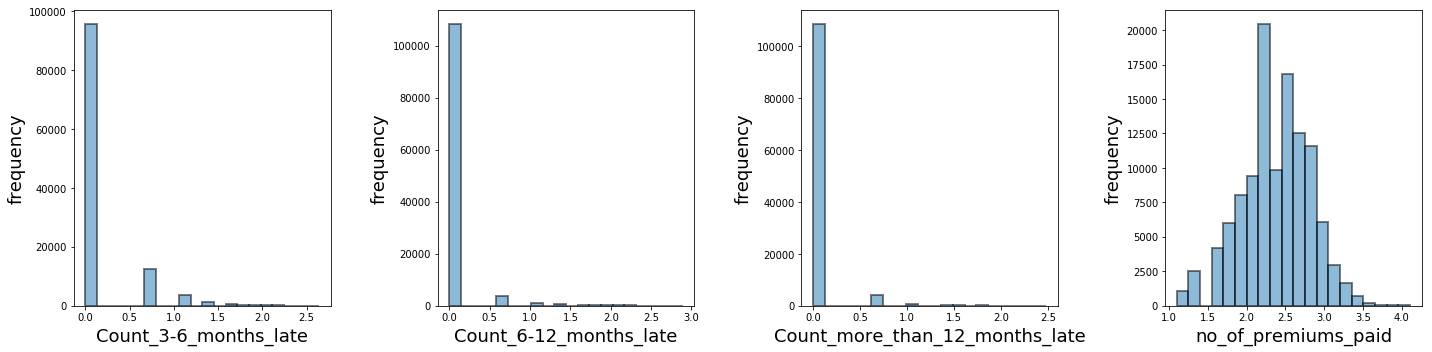

In [26]:
plot_histgrams(discrete_data.apply(lambda x: np.log1p(x)))

#### Count_3-6_months_late : No of premiums late by 3 to 6 months

In [27]:
count_3_6_crosstab = pd.crosstab(train_df['Count_3-6_months_late'],
            train_df['renewal'],margins=True).style.background_gradient(cmap='summer_r')

count_3_6_crosstab

renewal,0,1,All
Count_3-6_months_late,,,
0.0,2627,64174,66801
1.0,1153,7673,8826
2.0,592,1927,2519
3.0,288,666,954
4.0,158,216,374
5.0,67,101,168
6.0,31,37,68
7.0,10,13,23
8.0,6,9,15


In [28]:
count_3_6_crosstab_without_style = pd.crosstab(train_df['Count_3-6_months_late'],
            train_df['renewal'],margins=True).reset_index(drop=True)

count_3_6_crosstab_without_style['percentage'] = count_3_6_crosstab_without_style[1]/count_3_6_crosstab_without_style['All']

count_3_6_crosstab_without_style

renewal,0,1,All,percentage
0,2627,64174,66801,0.960674
1,1153,7673,8826,0.869363
2,592,1927,2519,0.764986
3,288,666,954,0.698113
4,158,216,374,0.577540
5,67,101,168,0.601190
6,31,37,68,0.544118
7,10,13,23,0.565217
8,6,9,15,0.600000
9,2,2,4,0.500000


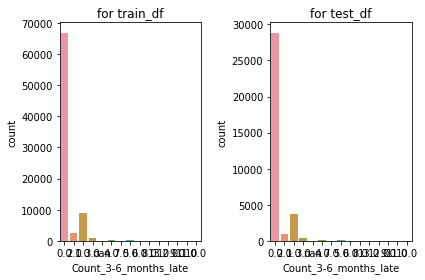

In [29]:
plt.subplot(1, 2, 1)
sns.countplot('Count_3-6_months_late',order=train_df['Count_3-6_months_late'].unique(),data=train_df);
plt.title('for train_df')
plt.subplot(1, 2, 2)
sns.countplot('Count_3-6_months_late',order=train_df['Count_3-6_months_late'].unique(),data=test_df);
plt.title('for test_df')
plt.tight_layout()

#### Count_6-12_months_late : No of premiums late by 6 to 12 months

In [30]:
count_6_12_crosstab = pd.crosstab(train_df['Count_6-12_months_late'],
            train_df['renewal'],margins=True).style.background_gradient(cmap='summer_r')

count_6_12_crosstab

renewal,0,1,All
Count_6-12_months_late,,,
0.0,3445,72386,75831
1.0,828,1852,2680
2.0,334,359,693
3.0,185,132,317
4.0,85,45,130
5.0,30,16,46
6.0,13,13,26
7.0,7,4,11
8.0,3,2,5


In [31]:
count_6_12_crosstab_without_style = pd.crosstab(train_df['Count_6-12_months_late'],
            train_df['renewal'],margins=True).reset_index(drop=True)

count_6_12_crosstab_without_style['percentage'] = count_6_12_crosstab_without_style[1]/count_6_12_crosstab_without_style['All']

count_6_12_crosstab_without_style

renewal,0,1,All,percentage
0,3445,72386,75831,0.954570
1,828,1852,2680,0.691045
2,334,359,693,0.518038
3,185,132,317,0.416404
4,85,45,130,0.346154
5,30,16,46,0.347826
6,13,13,26,0.500000
7,7,4,11,0.363636
8,3,2,5,0.400000
9,2,2,4,0.500000


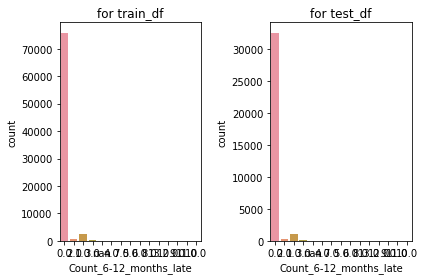

In [32]:
plt.subplot(1, 2, 1)
sns.countplot('Count_6-12_months_late',order=train_df['Count_3-6_months_late'].unique(),data=train_df);
plt.title('for train_df')
plt.subplot(1, 2, 2)
sns.countplot('Count_6-12_months_late',order=train_df['Count_3-6_months_late'].unique(),data=test_df);
plt.title('for test_df')
plt.tight_layout()

#### Count_more_than_12_months_late : No of premiums late by more than 12 months

In [33]:
count_more_than_12_crosstab = pd.crosstab(train_df['Count_more_than_12_months_late'],
            train_df['renewal'],margins=True).style.background_gradient(cmap='summer_r')

count_more_than_12_crosstab

renewal,0,1,All
Count_more_than_12_months_late,,,
0.0,3750,72288,76038
1.0,835,2161,2996
2.0,228,270,498
3.0,85,66,151
4.0,25,23,48
5.0,7,6,13
6.0,4,2,6
7.0,2,1,3
8.0,1,1,2


In [34]:
count_more_than_12_crosstab_without_style = pd.crosstab(train_df['Count_more_than_12_months_late'],
            train_df['renewal'],margins=True).reset_index(drop=True)

count_more_than_12_crosstab_without_style['percentage'] = count_more_than_12_crosstab_without_style[1]/count_more_than_12_crosstab_without_style['All']

count_more_than_12_crosstab_without_style

renewal,0,1,All,percentage
0,3750,72288,76038,0.950683
1,835,2161,2996,0.721295
2,228,270,498,0.542169
3,85,66,151,0.437086
4,25,23,48,0.479167
5,7,6,13,0.461538
6,4,2,6,0.333333
7,2,1,3,0.333333
8,1,1,2,0.500000
9,1,0,1,0.000000


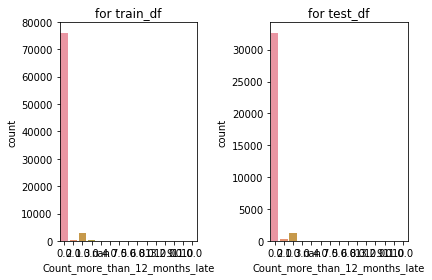

In [35]:
plt.subplot(1, 2, 1)
sns.countplot('Count_more_than_12_months_late',order=train_df['Count_3-6_months_late'].unique(),data=train_df);
plt.title('for train_df')
plt.subplot(1, 2, 2)
sns.countplot('Count_more_than_12_months_late',order=train_df['Count_3-6_months_late'].unique(),data=test_df);
plt.title('for test_df')
plt.tight_layout()

#### no_of_premiums_paid : Total premiums paid on time till now

In [36]:
no_of_premiums_paid_crosstab = pd.crosstab(train_df['renewal'],train_df['no_of_premiums_paid'],
            margins=True)
no_of_premiums_paid_crosstab

no_of_premiums_paid,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,58,59,60,All
renewal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,215,235,271,325,319,379,371,351,326,351,294,266,237,179,179,151,120,89,79,51,50,33,29,23,15,8,12,8,6,5,6,2,1,2,0,0,3,0,0,1,0,1,0,1,1,0,0,2,0,0,0,0,0,0,0,1,0,4998
1,511,1511,2636,3890,5316,6244,6813,6807,6547,6044,5113,4486,3751,3085,2499,1997,1679,1266,1055,787,663,470,357,282,226,178,140,111,85,56,45,41,37,29,23,14,5,5,6,5,7,2,4,2,4,3,1,1,3,2,2,2,1,3,2,0,1,74855
All,726,1746,2907,4215,5635,6623,7184,7158,6873,6395,5407,4752,3988,3264,2678,2148,1799,1355,1134,838,713,503,386,305,241,186,152,119,91,61,51,43,38,31,23,14,8,5,6,6,7,3,4,3,5,3,1,3,3,2,2,2,1,3,2,1,1,79853


In [37]:
no_of_premiums_paid_no_style = pd.crosstab(train_df['no_of_premiums_paid'],
            train_df['renewal'],margins=True).reset_index(level=0)

no_of_premiums_paid_no_style['percentage'] = no_of_premiums_paid_no_style[1] / no_of_premiums_paid_no_style['All']

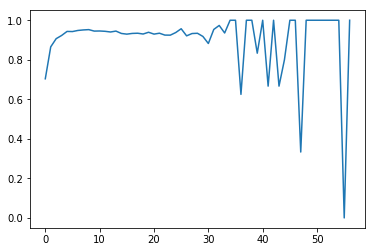

In [38]:
no_of_premiums_paid_no_style.percentage[:-1].plot()

# Continues Data

In [39]:
CONTINUOUS_COLUMNS

['perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'application_underwriting_score',
 'premium']

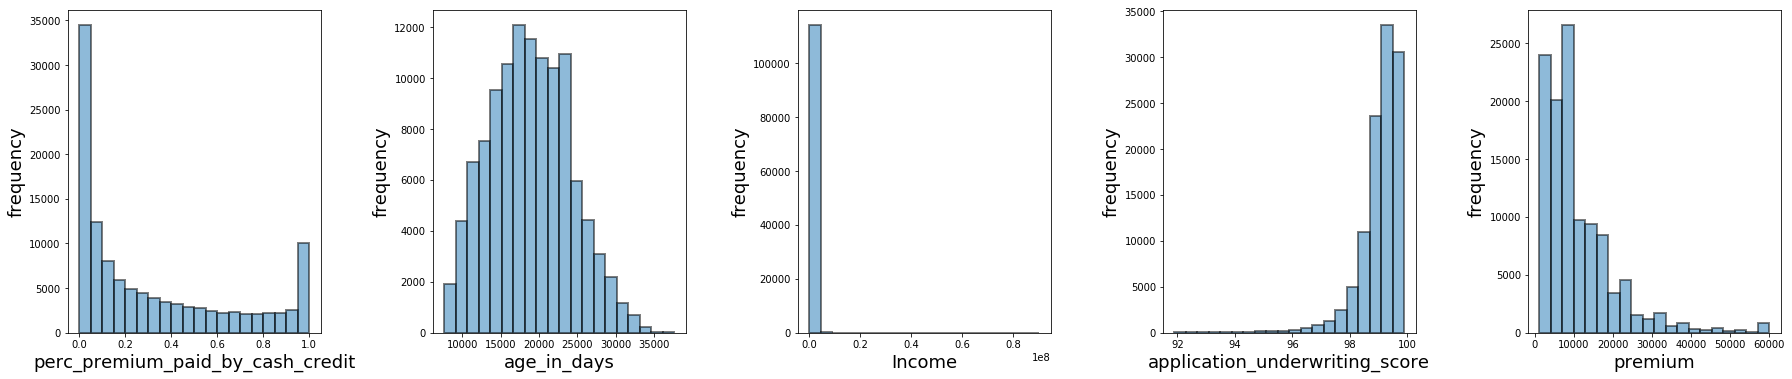

In [40]:
plot_histgrams(continuous_data)

In [41]:
continuous_data_log = continuous_data.apply(lambda x: np.log1p(x))

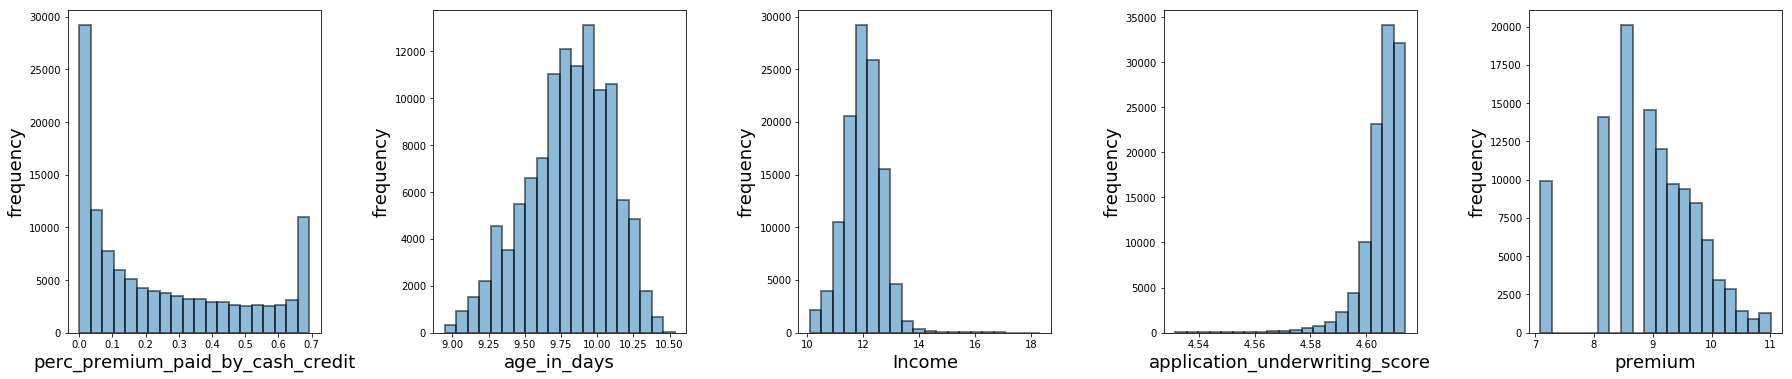

In [42]:
plot_histgrams(continuous_data_log)

In [43]:
continuous_data_norm = pd.DataFrame()
# preprocessing continuous_data
for col in continuous_data.columns:
    continuous_data_norm[col] = preproc_quantitatives(continuous_data[col])

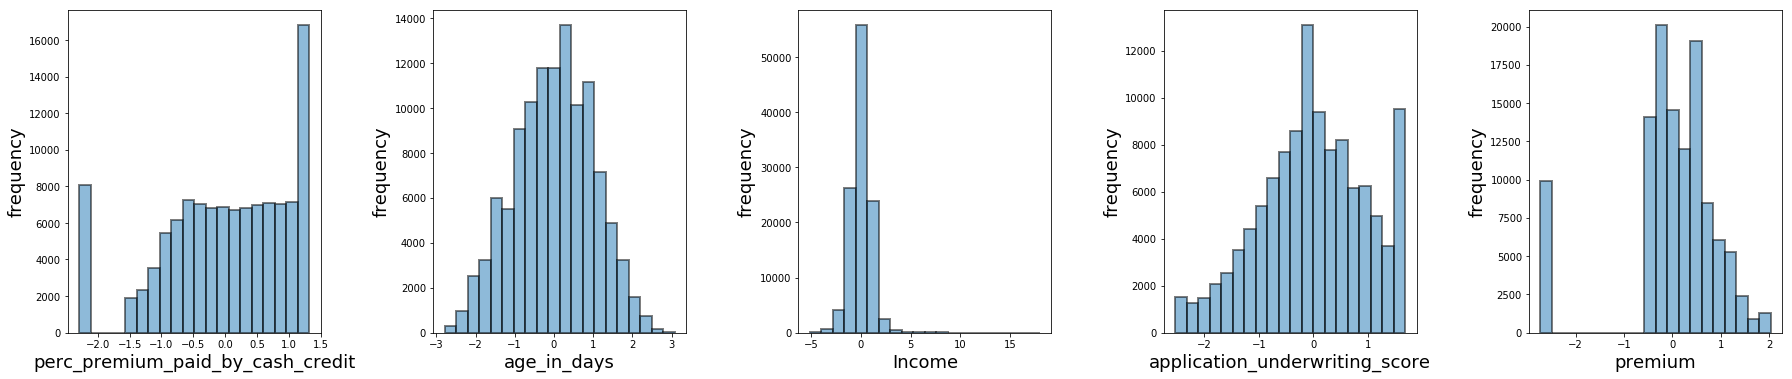

In [44]:
plot_histgrams(continuous_data_norm)

#### 'perc_premium_paid_by_cash_credit' : Percentage of premium amount paid by cash or credit card

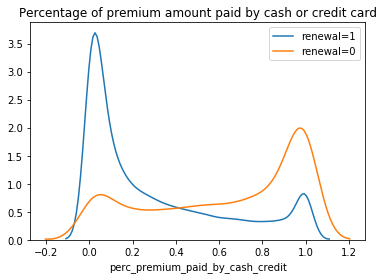

In [45]:
sns.distplot(train_df.loc[train_df['renewal']==1,'perc_premium_paid_by_cash_credit'],label='renewal=1',hist=False,norm_hist=True)
sns.distplot(train_df.loc[train_df['renewal']==0,'perc_premium_paid_by_cash_credit'],label='renewal=0',hist=False,norm_hist=True)
plt.title('Percentage of premium amount paid by cash or credit card');

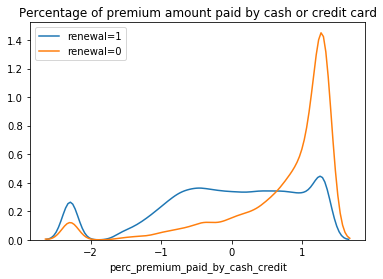

In [46]:
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'perc_premium_paid_by_cash_credit'],label='renewal=1',hist=False,norm_hist=True)
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'perc_premium_paid_by_cash_credit'],label='renewal=0',hist=False,norm_hist=True)
plt.title('Percentage of premium amount paid by cash or credit card');

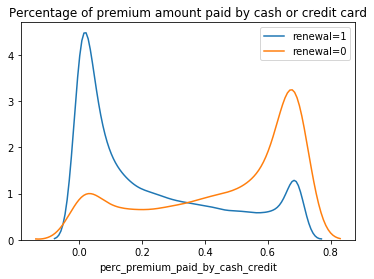

In [47]:
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'perc_premium_paid_by_cash_credit'],label='renewal=1',hist=False,norm_hist=True)
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'perc_premium_paid_by_cash_credit'],label='renewal=0',hist=False,norm_hist=True)
plt.title('Percentage of premium amount paid by cash or credit card');

In [48]:
print('renewal==1')
print(continuous_data.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'perc_premium_paid_by_cash_credit'].describe())
print('\nrenewal==0')
print(continuous_data.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'perc_premium_paid_by_cash_credit'].describe())

renewal==1
count    74855.000000
mean         0.293433
std          0.323140
min          0.000000
25%          0.031000
50%          0.148000
75%          0.487000
max          1.000000
Name: perc_premium_paid_by_cash_credit, dtype: float64

renewal==0
count    4998.000000
mean        0.626626
std         0.352369
min         0.000000
25%         0.317000
50%         0.728000
75%         0.971000
max         1.000000
Name: perc_premium_paid_by_cash_credit, dtype: float64


#### 'age_in_days' : Age in days of policy holder

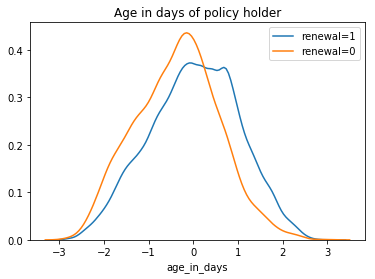

In [49]:
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'age_in_days'],label='renewal=1',hist=False,norm_hist=True)
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'age_in_days'],label='renewal=0',hist=False,norm_hist=True)
plt.title('Age in days of policy holder');

#### 'Income'

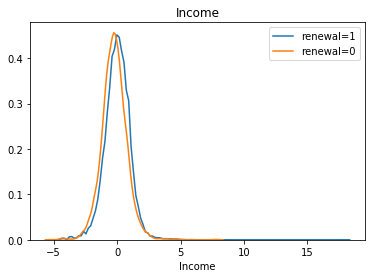

In [50]:
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'Income'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'Income'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

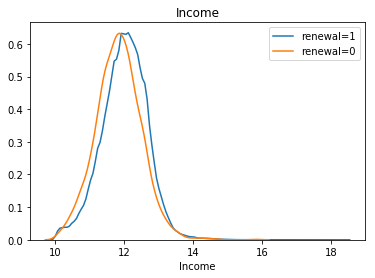

In [51]:
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'Income'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'Income'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

In [52]:
age_income_re = continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),['Income','age_in_days']]
age_income_nore = continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),['Income','age_in_days']]

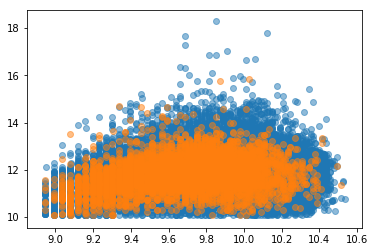

In [53]:
plt.scatter(age_income_re.iloc[:,1],age_income_re.iloc[:,0],alpha=.5)
plt.scatter(age_income_nore.iloc[:,1],age_income_nore.iloc[:,0],alpha=.5)

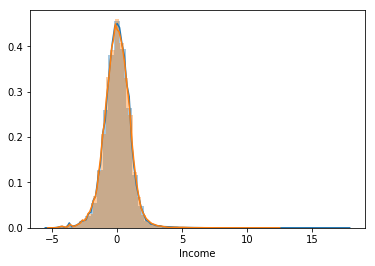

In [54]:
sns.distplot(preproc_quantitatives(train_df.Income),hist=True)
sns.distplot(preproc_quantitatives(test_df.Income),hist=True)

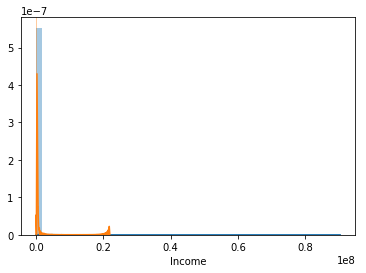

In [55]:
sns.distplot((train_df.Income),hist=True)
sns.distplot((test_df.Income),hist=True)

#### 'application_underwriting_score' : Underwriting Score of the applicant at the time of application (No applications under the score of 90 are insured)

In [56]:
continuous_data.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'application_underwriting_score'].describe()

count    72081.000000
mean        99.080407
std          0.727809
min         91.900000
25%         98.830000
50%         99.220000
75%         99.540000
max         99.890000
Name: application_underwriting_score, dtype: float64

In [57]:
continuous_data.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'application_underwriting_score'].describe()

count    4798.000000
mean       98.870256
std         0.877734
min        92.240000
25%        98.530000
50%        99.050000
75%        99.480000
max        99.890000
Name: application_underwriting_score, dtype: float64

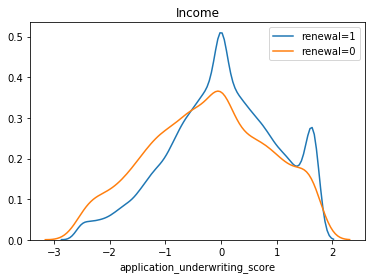

In [58]:
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'application_underwriting_score'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'application_underwriting_score'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

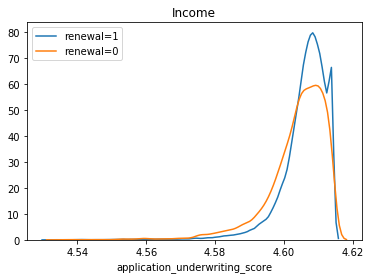

In [59]:
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'application_underwriting_score'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'application_underwriting_score'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

#### 'premium' : Monthly premium amount

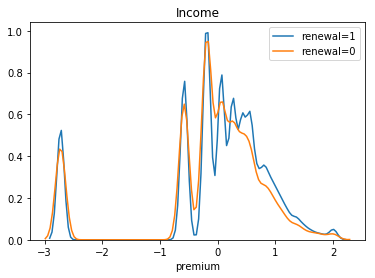

In [60]:
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'premium'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data_norm.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'premium'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

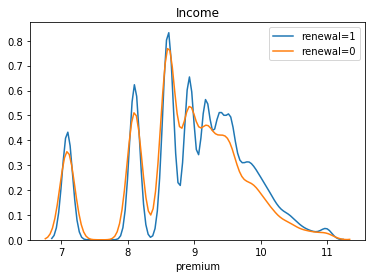

In [61]:
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'premium'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data_log.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'premium'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

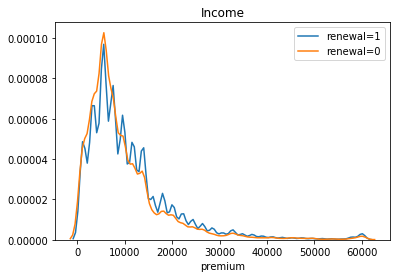

In [62]:
sns.distplot(continuous_data.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==1].index.tolist(),'premium'],label='renewal=1',hist=False,norm_hist=False)
sns.distplot(continuous_data.reset_index(drop=True).loc[train_df.loc[train_df['renewal']==0].index.tolist(),'premium'],label='renewal=0',hist=False,norm_hist=False)
plt.title('Income');

In [63]:
train_df['premium'].describe()

count    79853.000000
mean     10924.507533
std       9401.676542
min       1200.000000
25%       5400.000000
50%       7500.000000
75%      13800.000000
max      60000.000000
Name: premium, dtype: float64

#### ID

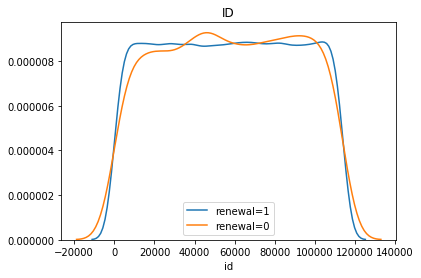

In [64]:
sns.distplot(train_df.loc[train_df['renewal']==1,'id'],label='renewal=1',hist=False,norm_hist=True)
sns.distplot(train_df.loc[train_df['renewal']==0,'id'],label='renewal=0',hist=False,norm_hist=True)
plt.title('ID');

# Correlation Analysis

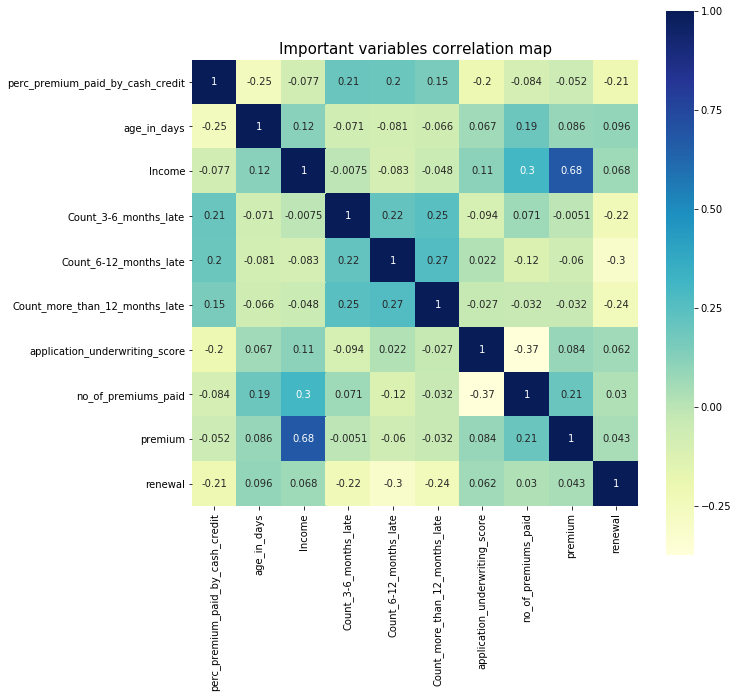

In [65]:
temp_df = train_df.iloc[:,1:]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

#### Concat datasets and Imput Missing Values

In [66]:
total_df = pd.concat([continuous_data,discrete_data,categorical_data_bin],axis=1)

In [67]:
# print(total_df.shape)

# print(train_df.shape[0]+test_df.shape[0])

In [68]:
total_df.loc[total_df['application_underwriting_score'].isnull(),'application_underwriting_score'] =  total_df['application_underwriting_score'].mean()

In [69]:
colsToImpute = []
for i,j in total_df.isnull().sum().reset_index().values:
    if j>0:colsToImpute.append(i)

In [70]:
for col in colsToImpute:
#     print(stats.mode(total_df[col].values)[0])
    total_df.loc[total_df[col].isnull(),col] =  stats.mode(total_df[col].values)[0]

In [71]:
# total_df.shape

In [72]:
# Train and test
train_idx = range(0, len(train_df))
test_idx = range(len(train_df), len(total_df))

In [73]:
# Train and test
train_shape = train_df.shape[0]
test_shape = test_df.shape[0]

# Check Distributions - Classification of Test vs. Train

In [74]:
def test_prediction(data):
    """Try to classify train/test samples from total dataframe"""

    # Create a target which is 1 for training rows, 0 for test rows
    y = np.zeros(len(data))
    y[train_idx] = 1

    # Perform shuffled CV predictions of train/test label
    predictions = cross_val_predict(
        ensemble.ExtraTreesClassifier(n_estimators=100, n_jobs=4),
        data, y,
        cv=StratifiedKFold(
            n_splits=10,
            shuffle=True,
            random_state=42
        )
    )

    # Show the classification report
    print(classification_report(y, predictions))
    
# Run classification on total raw data
test_prediction(total_df)

             precision    recall  f1-score   support

        0.0       0.30      0.04      0.07     34224
        1.0       0.70      0.96      0.81     79853

avg / total       0.58      0.68      0.59    114077



## Compare Features

In [75]:
for col in total_df.columns:
    statistic, pvalue = stats.ks_2samp(total_df.loc[:train_idx[-1],col].values,
    total_df.loc[train_idx[-1]:,col].values)
    print(col,pvalue)

perc_premium_paid_by_cash_credit 0.7589243577328716
age_in_days 0.3543618610893989
Income 0.044047000847659036
application_underwriting_score 0.7118240274061267
premium 0.8135397533260771
Count_3-6_months_late 0.47424163700671906
Count_6-12_months_late 1.0000000000000002
Count_more_than_12_months_late 0.9999999999100931
no_of_premiums_paid 0.9186914087241783
sourcing_channel_B 0.7158936484990348
sourcing_channel_C 0.9999999999999999
sourcing_channel_D 1.0000000000000007
sourcing_channel_E 1.0000000000000142
residence_area_type_Urban 0.9999999999999714


#### Are distributions of train and the test sets the same? - Seems the same

# Feature Importance - Extra trees model

#### First transform features for model

In [76]:
### Get the X and y variables for building model ###
train_X = total_df.iloc[:train_shape,:]
test_X = total_df.iloc[train_shape:,:]
train_y = train_df["renewal"].values

#### Feature Importance & Baseline - RandomForestClassifier

In [77]:
model = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [78]:
## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

In [79]:
# train_df.columns

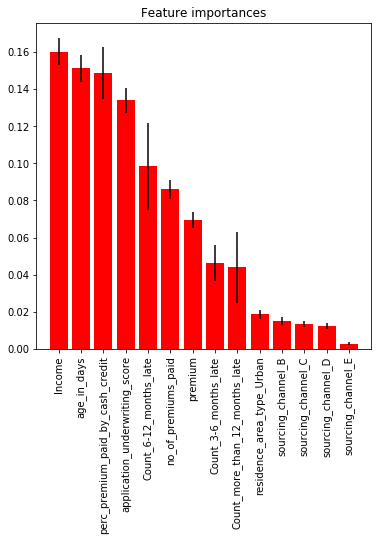

In [80]:
plt.figure(figsize=(6,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

#### Feature Importance & Baseline - Light GBM

In [81]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], 
                      early_stopping_rounds=100, verbose_eval=200, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [82]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    
pred_test_full /= 5.
# pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.846178
[400]	valid_0's auc: 0.847538
[600]	valid_0's auc: 0.84791
Early stopping, best iteration is:
[606]	valid_0's auc: 0.847981
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.840158
[400]	valid_0's auc: 0.840836
Early stopping, best iteration is:
[313]	valid_0's auc: 0.84103
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.840584
[400]	valid_0's auc: 0.841909
[600]	valid_0's auc: 0.842346
Early stopping, best iteration is:
[535]	valid_0's auc: 0.842482
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.844038
Early stopping, best iteration is:
[281]	valid_0's auc: 0.844871
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.837367
Early stopping, best iteration is:
[295]	valid_0's auc: 0.837945


In [83]:
pred_X = model.predict(train_X)

In [84]:
# test_df.shape

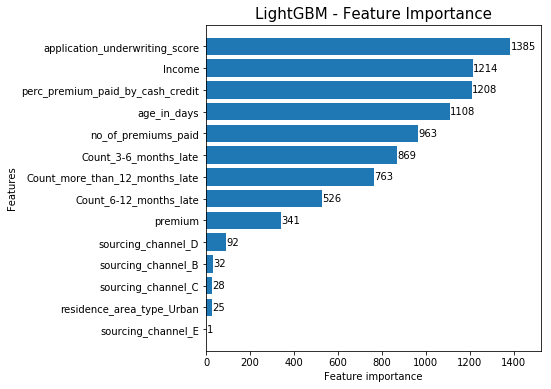

In [85]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(6,6))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# Metric

In [86]:
fpr, tpr, _ = roc_curve(train_y, pred_X)
roc_auc = auc(fpr, tpr)
print('roc_auc score: {}'.format(roc_auc))

roc_auc score: 0.8528820732755061


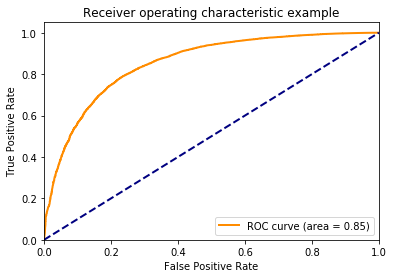

In [87]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ref:

- Info about insurance business : http://www.lifeant.com/life-insurance-commissions-how-life-insurance-agents-are-paid/

- Some EDA ideas: https://www.kaggle.com/kkondo/ridge-regression-score-0-55443